<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-и-обработка-данных" data-toc-modified-id="Анализ-и-обработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ и обработка данных</a></span><ul class="toc-item"><li><span><a href="#Проверка-данных" data-toc-modified-id="Проверка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка данных</a></span></li><li><span><a href="#Анализ-целевого-признака-'num_orders'" data-toc-modified-id="Анализ-целевого-признака-'num_orders'-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Анализ целевого признака <code>'num_orders'</code></a></span></li><li><span><a href="#Тренд,-сезонность,-остатки" data-toc-modified-id="Тренд,-сезонность,-остатки-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тренд, сезонность, остатки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-базовой-модели-Prophet" data-toc-modified-id="Обучение-базовой-модели-Prophet-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучение базовой модели Prophet</a></span></li><li><span><a href="#Собственный-класс-для-создания-признаков-в-Pipeline" data-toc-modified-id="Собственный-класс-для-создания-признаков-в-Pipeline-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Собственный класс для создания признаков в Pipeline</a></span></li><li><span><a href="#Разбивка-данных-на-обучающую-и-тестовую-выборки." data-toc-modified-id="Разбивка-данных-на-обучающую-и-тестовую-выборки.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Разбивка данных на обучающую и тестовую выборки.</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#XGBRegressor" data-toc-modified-id="XGBRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>XGBRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод:</a></span></li><li><span><a href="#Рекомендации:" data-toc-modified-id="Рекомендации:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Рекомендации:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**План выполнения:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Данные хранятся в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Загрузка данных

In [1]:
!pip install prophet

# импорт библиотек для работы
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from prophet import Prophet

In [2]:
# определим константу для random_seed
RAND_ST = 777

# зададим константу определяющую текущее окружение
HUB = False
if os.environ['JUPYTERHUB_USER']:
    HUB = True
# загрузим данные в зависимости от окружения
if HUB:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
else:
    df = pd.read_csv('./mydatasets/taxi.csv', index_col=[0], parse_dates=[0])
    
df.sort_index(inplace=True)    
    
# выведем информацию по загруженному датасету
display(df.head())
display(df.tail())
display(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

**Описание данных:**
- в индексе содержатся данные о дате и времени с временным **интервалом в 10 минут**;
- есть один признак (столбец) с информацией о колиестве заказов такси;
- всего в датасете собрано **26 496** записей **с 1 марта 2018 года по 31 августа 2018 года**;
- пропущенных значений в данных нет.

## Анализ и обработка данных

### Проверка данных

Для начала проверим данные на монотонность.

In [3]:
print('Данные монотонны' if df.index.is_monotonic else 'Данные не монотонны!')

Данные монотонны


### Анализ целевого признака `'num_orders'`

In [4]:
# статистики
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


**Описание статистик:**
- **среднее значение заказов** в течение 10 минут составляет **14 заказов**;
- **медиана** по данному показателю составляет **13 заказов**;
- **минимальное количество заказов** в течение 10 минут равнялось **0**;
- **максимальное количество заказов** в течение 10 минут достигало **119**;
- **стандартное отклонение** - **9.2**.

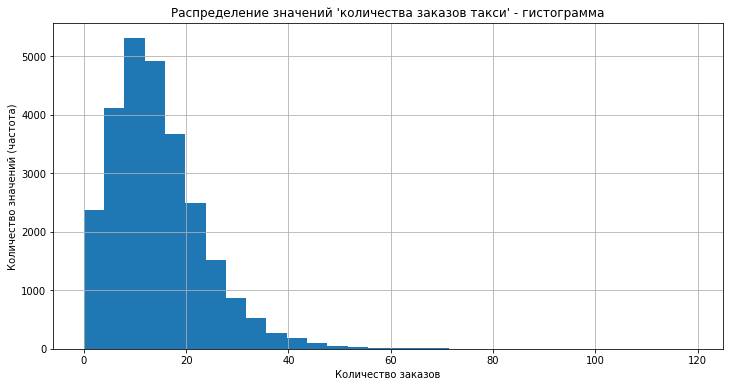

In [5]:
df.hist(bins=30, figsize=(12, 6))
plt.title("Распределение значений 'количества заказов такси' - гистограмма")
plt.xlabel('Количество заказов')
plt.ylabel('Количество значений (частота)')
plt.show();

Распределение значений целевого признака `'num_orders'`(*количество заказов*) **соответствует Пуассоновскому распределению**.

Проведем **ресемплирование** данных с интервалом **в один час** и **суммированием количества заказов** и отобразим общий график за весь представленнный период. 

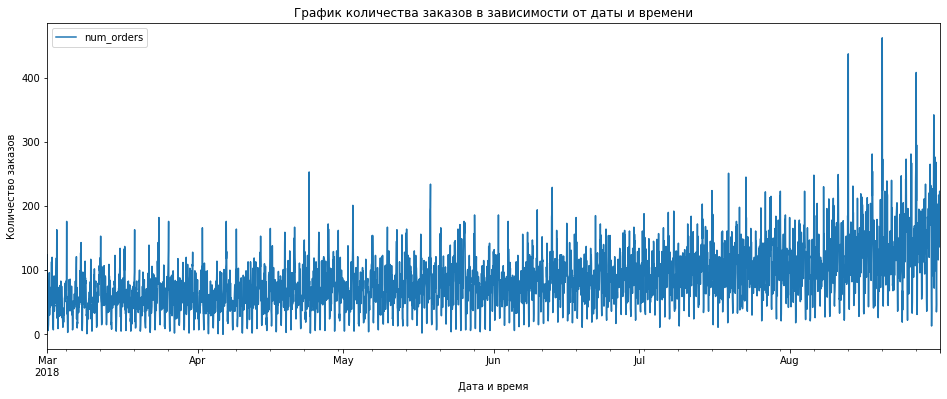

In [6]:
# ресемплирование данных по одному часу
df = df.resample('1H').sum()

# построим график
df.plot(ax=plt.gca(), figsize=(16, 6))
plt.title('График количества заказов в зависимости от даты и времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.show();

На графике хорошо заметен **восходящий тренд среднего количества заказов такси с апреля по конец августа 2018 года** (временной ряд не стационарен). Так же в августе отмечается **4 аномально высоких значений количества заказов**. 

### Тренд, сезонность, остатки

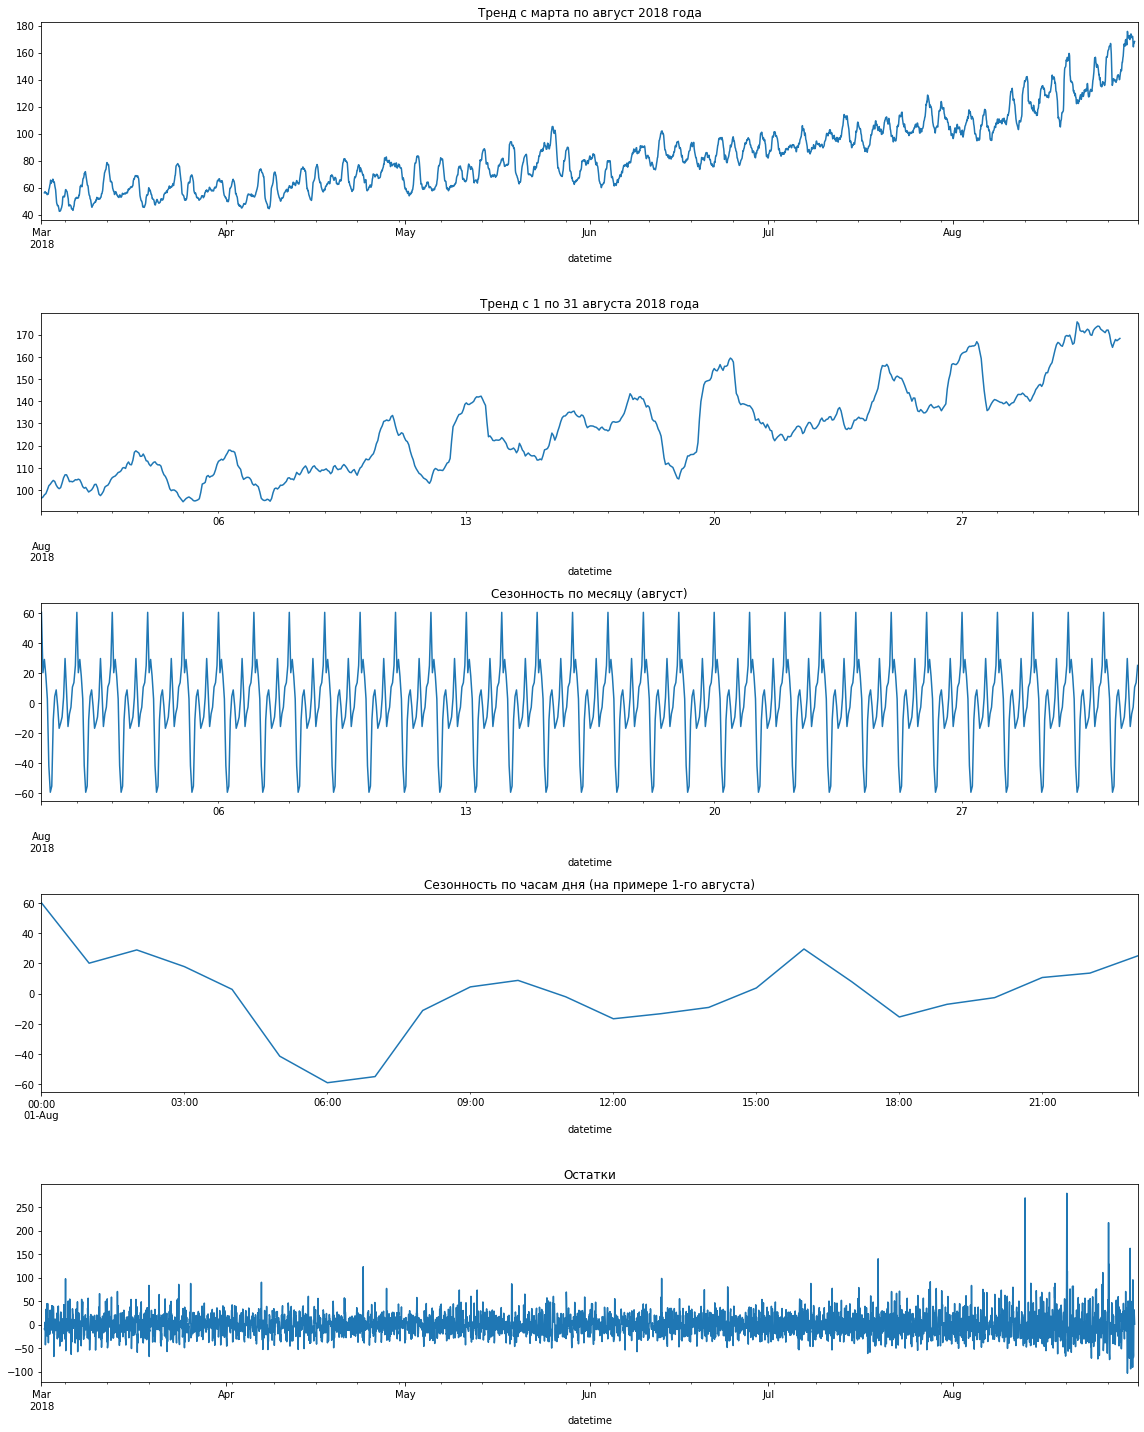

In [8]:
#постоим графики тренда, сезонности и остатков
decomposed = seasonal_decompose(df)

plt.figure(figsize=(16, 20))
plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд с марта по август 2018 года')

plt.subplot(512)
decomposed.trend['2018-08'].plot(ax=plt.gca())
plt.title('Тренд с 1 по 31 августа 2018 года')

plt.subplot(513)
decomposed.seasonal['2018-08'].plot(ax=plt.gca())
plt.title('Сезонность по месяцу (август)')

plt.subplot(514)
decomposed.seasonal['2018-08-01'].plot(ax=plt.gca())
plt.title('Сезонность по часам дня (на примере 1-го августа)')

plt.subplot(515)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

**Выводы:**
- существует определенный **восходящий тренд** с **апреля по конец августа 2018 года**. Признак `месяц` и `день месяца` будут являться хорошими прогностическими факторамм;
- присутствует сезонность в дне недели. Например в каждый 6-ой день месяца количество заказов значительно больше, чем в предыдущий 5-ый день. Признак `день недели` возможно будет являться хорошим прогностическим фактором;
- так же присутствует сезонность во времени суток. Ближе к 6 утра количество заказов минимально, пик наблюдается во второй половине дня и ночью. Признак `час` (или `время суток`) будет являться хорошим прогностическим фактором;
- в остатках наблюдаются отмеченные ранее пики в агусте месяце.

## Обучение

### Обучение базовой модели Prophet

Для обучения базовой модели выберем библиотеку **Prophet**, которая работает "из под коробки".

In [9]:
# переименуем колонки для Prophet
df_prophet = pd.DataFrame({'ds': df.index, 'y': df.num_orders}).reset_index(drop=True)
df_prophet.head()

,ds,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


In [10]:
# разделим выборку на train и valid
train_pr, valid_pr = train_test_split(df_prophet, test_size=.1, shuffle=False)
print('Обучающая выборка:')
print(f'Размер: {train_pr.shape}\nДанные:\n {train_pr}')
print('Валидационная выборка:')
print(f'Размер: {valid_pr.shape}\nДанные:\n {valid_pr}')

Обучающая выборка:
Размер: (3974, 2)
Данные:
                       ds    y
0    2018-03-01 00:00:00  124
1    2018-03-01 01:00:00   85
2    2018-03-01 02:00:00   71
3    2018-03-01 03:00:00   66
4    2018-03-01 04:00:00   43
...                  ...  ...
3969 2018-08-13 09:00:00  137
3970 2018-08-13 10:00:00  156
3971 2018-08-13 11:00:00  144
3972 2018-08-13 12:00:00   92
3973 2018-08-13 13:00:00  119

[3974 rows x 2 columns]
Валидационная выборка:
Размер: (442, 2)
Данные:
                       ds    y
3974 2018-08-13 14:00:00  102
3975 2018-08-13 15:00:00  175
3976 2018-08-13 16:00:00  144
3977 2018-08-13 17:00:00  152
3978 2018-08-13 18:00:00  104
...                  ...  ...
4411 2018-08-31 19:00:00  136
4412 2018-08-31 20:00:00  154
4413 2018-08-31 21:00:00  159
4414 2018-08-31 22:00:00  223
4415 2018-08-31 23:00:00  205

[442 rows x 2 columns]


In [11]:
%%time

# обучим модель Prophet
model_pr = Prophet()
model_pr.fit(train_pr)

11:04:00 - cmdstanpy - INFO - Chain [1] start processing
11:04:02 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 163 ms, sys: 31.6 ms, total: 194 ms
Wall time: 2.36 s


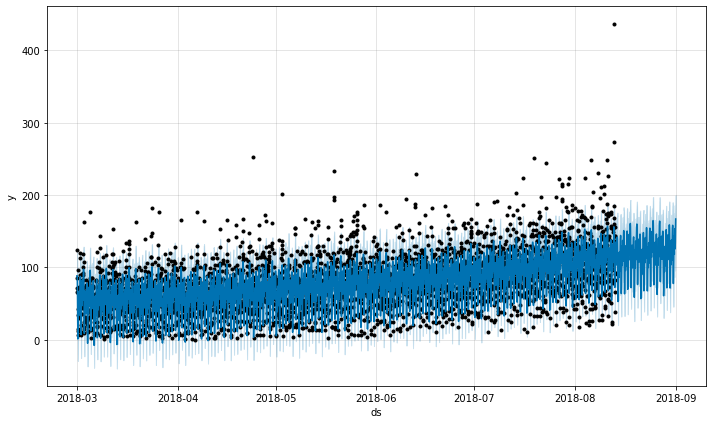

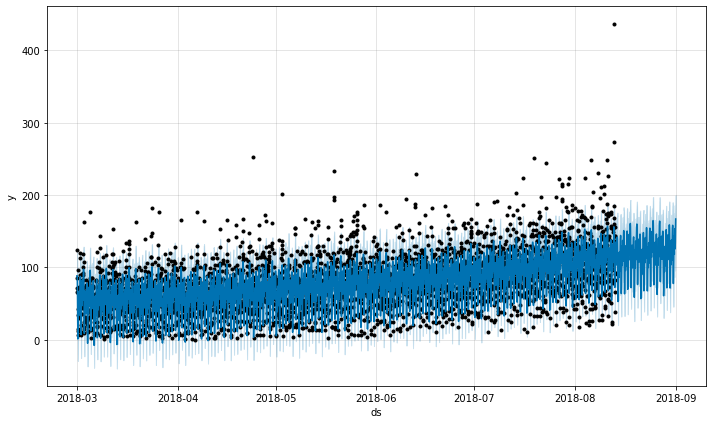

In [12]:
# получим предсказания модели Prophet
future = model_pr.make_future_dataframe(periods=valid_pr.shape[0], freq='H')
forecast = model_pr.predict(future)
# выведем общий график предсказаний
model_pr.plot(forecast)

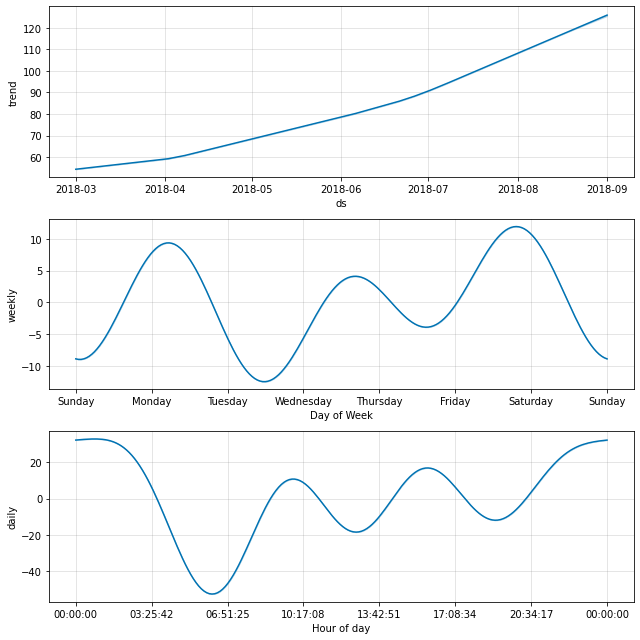

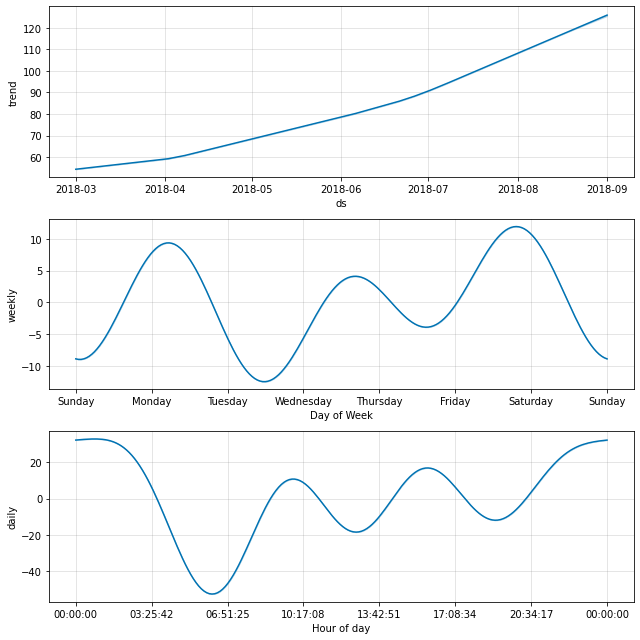

In [13]:
# выведем тренд и сезонность по дням недели и часам
model_pr.plot_components(forecast)

- Как видно модель Prophet так же выделила общий **восходящий тренд**. Особенность здесь в том, что в линии тренда присутствуют точки перелома, **линия тренда** не прямая, а скорее **имеет нелинейный характер** с постепенным увеличением к концу года;
- как было отмечено на этапе анализа данных существует **сезонность по дням недели и времени суток**.

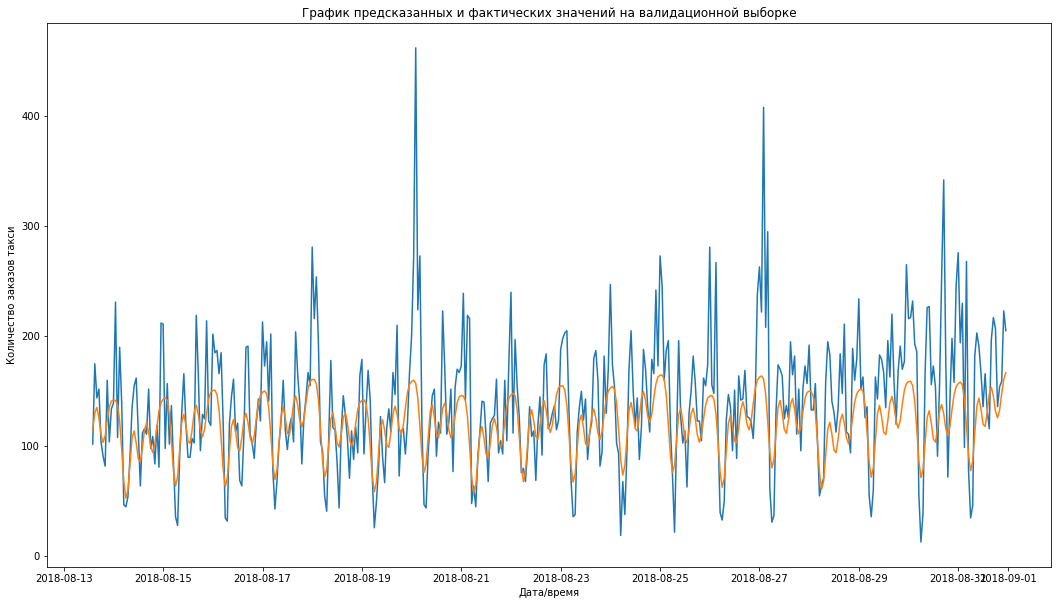

In [14]:
# построим график предсказания и фактических значений для валидационной выборки
plt.figure(figsize=(18, 10))
plt.plot(valid_pr.ds, valid_pr.y)
plt.plot(valid_pr.ds, forecast.loc[train_pr.shape[0]:, 'yhat'].values)
plt.title('График предсказанных и фактических значений на валидационной выборке')
plt.ylabel('Количество заказов такси')
plt.xlabel('Дата/время')
plt.show();

Из графика видно, что предсказанные значения повторяют динамику фактических, но имеет очень сглаженный характер. 

In [15]:
# выведем метрику качества RMSE на валидационной выборке

model_pr_rmse = mean_squared_error(valid_pr.y, forecast.loc[train_pr.shape[0]:, 'yhat'].values, squared=False)
print('RMSE на валидационной выборке базовой модели с Prophet:', end=' ')
print(model_pr_rmse)

RMSE на валидационной выборке базовой модели с Prophet: 48.19672268933649


 ### Собственный класс для создания признаков в Pipeline
 
 Напишем свой класс для предобработки данных для использования в Pipeline.

In [16]:
class DataPreprocess(BaseEstimator, TransformerMixin):
    '''
    Класс предобработки train/test выборки для этапа Pipeline в обучении моделей предсказания
    Класс включает в себя следующие этапы предобработки:
    1. Создание 3-х новых признаков (trend, daily, weekly) на train-выборке с использованием Prophet;
    2. Создание новых признаков на оcнове смещения (lag), по умолчанию значение 1;
    3. Создание новых признаков на оcнове скользящего среднего (rolling), по умолчанию значение 1;
    4. Создание новых признаков на оcнове календарных данных; 
    5. Удаление записей со значением Nan в train-выборке, после создания признаков.
    
    ВАЖНО: в класс должны подаваться отсортированные в порядке возрастания по индексу (datetime) данные,
    без пропусков. Test-выборка должны продолжать временной ряд train-выборки без разрыва во времени.
    '''
    # инициализация объекта с дефолтными параметрами 
    def __init__(self, rolling_mean_size=3, lag=1):
        self.rolling_mean_size = rolling_mean_size
        self.lag = lag
        
    def get_model_feat_prophet(self, df):
        '''
        Функция для обучения модели Prophet, а так же полуяения дополнительных признаков trend, daily, weekly.
        Функция возвращает кортеж из модели и дополнительных признаков.
        '''
        df_prophet = pd.DataFrame({'ds': df.index, 'y': df.num_orders}).reset_index(drop=True)
        model_pr = Prophet()
        model_pr.fit(df_prophet)
        future = model_pr.make_future_dataframe(periods=0, freq='H')
        forecast = model_pr.predict(future) 
        return model_pr, forecast[['trend', 'daily', 'weekly']]
    
    def get_calendar_feat(self, df):
        '''
        Функция принимает dataframe, расчитывает календарные признаки по его индексу
        и возвращает тот же dataframe, но уже с расчитанными календарными признаками. 
        '''
        # признак, в котором хранится месяц как число
        df['month'] = df.index.month
        # признак, в котором хранится день месяца как число
        df['day'] = df.index.day
        # признак, в котором хранится день недели как число
        df['dayofweek'] = df.index.dayofweek
        # признак, в котором хранится час суток как число
        df['hour'] = df.index.hour
        # категориальный признак, в котором хранится время суток (ночь, утро, день, вечер) как число (1, 2, 3, 4 - соотвественно)
        # для этого создадим отдельную функцию
        def get_order_time(date) -> int:
            '''
            Функция возвращает порядковый номер времени суток исходя из следующего правила:
            с 0 до 5 часов - ночь (кодировка - 1)
            с 5 до 11 часов - утро (кодировка - 2)
            с 11 до 17 часов - день (кодировка - 3)
            с 17 до 0 часов - вечер (кодировка - 4)
            '''
            if date.hour in range(6):
                return 1
            elif date.hour in range(5, 12):
                return 2
            elif date.hour in range(11, 18):
                return 3
            elif date.hour in range(17, 24):
                return 4
        df['order_time_of_day'] = df.index.map(get_order_time)
        
        # закодируем часы с помощью синуса и косинуса
        # credits - https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
        df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
        # удалим исходный признак hour как избыточный
        return df.drop('hour', axis=1)

    
    def fit(self, X, y=None):
        '''
        Метод fit. Данные проверяются на монотонность, в объект записывается целевой признак,
        а так же последние записи train-выборки для дальнейшего объединения с test-выборкой и расчета
        lag и rolling. Количество таких записей определяется наибольшим значение self.lag, self.rolling_mean_size.
        Так же в объекте сохраняется полученные из функции get_model_feat_prophet() модель Prophet и ее признаки.
        '''
        if not X.index.is_monotonic:
            raise ValueError('Проверьте отсортированы ли данные по времени!')
        self.y_train = y
        df_train = X.copy()
        # сохраним последние записи train-выборки для последующего объединения с test-выборкой
        last_len = max(self.lag, self.rolling_mean_size) * -1
        self.df_train_last = df_train.iloc[last_len:]
        # получим и сохраним обученную модель Prophet и необходимые признаки из нее
        self.model_pr, self.feat_prophet_tr = self.get_model_feat_prophet(df_train)
        
        return self
    
    # метод transform 
    def transform(self, X, y=None):
        '''
        Метод transform. В данном методе в зависимости от выборки train или test/valid расчитваются все 
        дополнительные признаки. Далле все признаки объединяются в один общий dataframe и возвращаются 
        в таком виде без целевого признака.
        ''' 
        X_ = X.copy()
        # получим данные с извлеченными календарными признаками
        X_ = self.get_calendar_feat(X_)
        
        # если train-выборка
        if getattr(self, 'X_train', None) is None:
            # подсчет lag-признаков
            for lag in range(1, self.lag + 1):
                X_['lag_{}'.format(lag)] = X_['num_orders'].shift(lag)
            # «Сглаживание по среднему» (rolling)
            if self.rolling_mean_size > 0:
                X_['rolling_mean'] = X_['num_orders'].shift().rolling(self.rolling_mean_size).mean()
            # объединим и сохраним в объекте все полученные признаки с обнулением индексов
            self.X_train = pd.concat([X_.reset_index(drop=True), self.feat_prophet_tr], axis=1)
            # удалим целевой признак `num_orders`
            self.X_train.drop('num_orders', axis=1, inplace=True)
            
            return self.X_train
            
        else: # если test/valid-выборка
            # сохраним в переменную число записей
            x_shape = X.shape[0]
            # объединим выборку с последними значениями из train-выборки
            df_test = pd.concat([self.df_train_last, X_])
            # если данные не хронологичны выведем ошибку
            if not df_test.index.is_monotonic:
                raise ValueError('''Между тестовой и обучающей выборкой недопустимый разрыв во времени! 
                                 Проверьте отсортированы ли данные по времени, а так же тестовую выборку!''')
            # подсчет lag-признаков
            for lag in range(1, self.lag + 1):
                df_test['lag_{}'.format(lag)] = df_test['num_orders'].shift(lag)
            # «Сглаживание по среднему» (rolling)
            if self.rolling_mean_size > 0:
                df_test['rolling_mean'] = df_test['num_orders'].shift().rolling(self.rolling_mean_size).mean()
            # удалим все записи с пропущенными значениями - записи из train-выборки
            df_test = df_test.dropna()
            # приведем тип данных по календарным призакам к типу int
            calendar_feat = ['month', 'day', 'dayofweek', 'order_time_of_day']
            df_test[calendar_feat] = df_test[calendar_feat].astype(int)
            # получим и сохраним необходимые признаки из модели Prophet 
            future = self.model_pr.make_future_dataframe(periods=x_shape, freq='H')
            forecast = self.model_pr.predict(future).reset_index(drop=True).iloc[-1 * x_shape:]
            self.feat_prophet_test = forecast[['trend', 'daily', 'weekly']]        
            # объединим и сохраним в объекте все полученные признаки с обнулением индексов
            self.X_test = pd.concat([df_test.reset_index(drop=True),
                                     self.feat_prophet_test.reset_index(drop=True)], axis=1)
            # удалим целевой признак `num_orders`
            self.X_test.drop('num_orders', axis=1, inplace=True)
            
            return self.X_test
       

### Разбивка данных на обучающую и тестовую выборки.

In [17]:
# разделим выборку на train и test в соотношении 90/10 %
df_train, df_test = train_test_split(df, test_size=.1, shuffle=False)

# создадим собственный объект препроцессора с предустановленными параметрами rolling и lag
preproccesor = DataPreprocess(rolling_mean_size=4, lag=2)

In [18]:
# создадим объект TimeSeriesSplit с кросс-валидацией на 3 фолдах и размером валидационной выборки в 450 точек
tscv = TimeSeriesSplit(n_splits=3, test_size=450)

### LGBMRegressor

In [19]:
# создадим Pipeline
pipe_gbm = make_pipeline(
    preproccesor,
    LGBMRegressor(
    metric='rmse',
        n_jobs=-1,
        verbosity=-1,
        random_state=RAND_ST
    )
)

# зададим параметры для поиска с помощью GridSearchCV
param_grid = {
    'lgbmregressor__max_depth': [-1], # [-1, 10, 15],
    'lgbmregressor__num_leaves': [13], # [5, 7, 10, 13],
    'lgbmregressor__learning_rate': [.1] # [.05, .1, .2, .3]
}
 
# зададим параметры для GridSearchCV    
grid_gbm = GridSearchCV(
    pipe_gbm,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv
)

In [20]:
%%time 

# обучим модель с поиском наилучших гиперпараметров и кросс-валидации на 3-х фолдах
grid_gbm.fit(df_train, df_train['num_orders'].values)

11:04:06 - cmdstanpy - INFO - Chain [1] start processing
11:04:09 - cmdstanpy - INFO - Chain [1] done processing
11:04:31 - cmdstanpy - INFO - Chain [1] start processing
11:04:33 - cmdstanpy - INFO - Chain [1] done processing
11:06:08 - cmdstanpy - INFO - Chain [1] start processing
11:06:10 - cmdstanpy - INFO - Chain [1] done processing
11:07:12 - cmdstanpy - INFO - Chain [1] start processing
11:07:14 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 4min 6s, sys: 4.33 s, total: 4min 10s
Wall time: 4min 20s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=450),
             estimator=Pipeline(steps=[('datapreprocess',
                                        DataPreprocess(lag=2,
                                                       rolling_mean_size=4)),
                                       ('lgbmregressor',
                                        LGBMRegressor(metric='rmse',
                                                      random_state=777,
                                                      verbosity=-1))]),
             n_jobs=-1,
             param_grid={'lgbmregressor__learning_rate': [0.1],
                         'lgbmregressor__max_depth': [-1],
                         'lgbmregressor__num_leaves': [13]},
             scoring='neg_root_mean_squared_error')

In [21]:
# сохраним результаты в общую таблицу и выведем метрику качества RMSE на валидационной выборке
model_gbm_rmse = abs(grid_gbm.best_score_)
models_res = [model_gbm_rmse]
print('Гиперпараметры лучшей модели:', grid_gbm.best_params_)
print('RMSE на кросс-валидации:', model_gbm_rmse)

Гиперпараметры лучшей модели: {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__max_depth': -1, 'lgbmregressor__num_leaves': 13}
RMSE на кросс-валидации: 25.56798648812362


### XGBRegressor

In [22]:
# создадим Pipeline
pipe_xgb = make_pipeline(
    preproccesor,
    XGBRegressor(
        eval_metric='rmse',
        use_label_encoder=False,
        n_jobs=-1,
        random_state=RAND_ST
    )
)

# зададим параметры для поиска с помощью GridSearchCV
param_grid = {
    'xgbregressor__max_depth': [4], #[2, 3, 4, 5],
    'xgbregressor__n_estimators': [130], # range(100, 250, 10),
    'xgbregressor__learning_rate': [0.03] # np.arange(0.01, 0.2, 0.01)
}

# параметры GridSearch
grid_xgb = GridSearchCV(
    pipe_xgb,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv
)


In [23]:
%%time 

grid_xgb.fit(df_train, df_train['num_orders'].values)

11:08:27 - cmdstanpy - INFO - Chain [1] start processing
11:08:29 - cmdstanpy - INFO - Chain [1] done processing
11:09:54 - cmdstanpy - INFO - Chain [1] start processing
11:09:56 - cmdstanpy - INFO - Chain [1] done processing
11:11:22 - cmdstanpy - INFO - Chain [1] start processing
11:11:24 - cmdstanpy - INFO - Chain [1] done processing
11:12:51 - cmdstanpy - INFO - Chain [1] start processing
11:12:53 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 5min 32s, sys: 5.03 s, total: 5min 37s
Wall time: 5min 48s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=450),
             estimator=Pipeline(steps=[('datapreprocess',
                                        DataPreprocess(lag=2,
                                                       rolling_mean_size=4)),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     enable_categorical=False,
                                                     eval_metric='rmse',
                                                     gamma=None...
                                                     num_parallel_tree=No

In [24]:
# сохраним результаты в общую таблицу и выведем метрику качества RMSE на валидационной выборке
model_xgb_rmse = abs(grid_xgb.best_score_)
models_res.append(model_xgb_rmse)
print('Гиперпараметры лучшей модели:', grid_xgb.best_params_)
print('RMSE на кросс-валидации:', model_xgb_rmse)

Гиперпараметры лучшей модели: {'xgbregressor__learning_rate': 0.03, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 130}
RMSE на кросс-валидации: 27.15055302760253


### CatBoostRegressor

In [25]:
# создадим Pipeline
pipe_ctb = make_pipeline(
    preproccesor,
    CatBoostRegressor(
        loss_function='RMSE',
        early_stopping_rounds = 30,
        random_state=RAND_ST
    )
)

# зададим параметры для поиска с помощью GridSearchCV
param_grid = {
    'catboostregressor__depth': [7], # range(3, 11),
    'catboostregressor__iterations': [3000], # [2000, 3000, 4000],
    'catboostregressor__learning_rate': [0.005] # np.arange(0.001, 0.2, 0.001)
}

# параметры GridSearch
grid_ctb = GridSearchCV(
    pipe_ctb,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv
)

In [26]:
%%time 

grid_ctb.fit(df_train, df_train['num_orders'].values)

11:14:16 - cmdstanpy - INFO - Chain [1] start processing
11:14:18 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 33.3282844	total: 53.5ms	remaining: 2m 40s
1:	learn: 33.2385991	total: 57.6ms	remaining: 1m 26s
2:	learn: 33.1531224	total: 60.1ms	remaining: 60s
3:	learn: 33.0708029	total: 62.6ms	remaining: 46.9s
4:	learn: 32.9834398	total: 65.1ms	remaining: 39s
5:	learn: 32.9005348	total: 67.7ms	remaining: 33.8s
6:	learn: 32.8159356	total: 71.1ms	remaining: 30.4s
7:	learn: 32.7321299	total: 73.5ms	remaining: 27.5s
8:	learn: 32.6596663	total: 76ms	remaining: 25.3s
9:	learn: 32.5761503	total: 78.6ms	remaining: 23.5s
10:	learn: 32.4908962	total: 81.2ms	remaining: 22.1s
11:	learn: 32.4071118	total: 83.4ms	remaining: 20.8s
12:	learn: 32.3282282	total: 85.7ms	remaining: 19.7s
13:	learn: 32.2451973	total: 88.2ms	remaining: 18.8s
14:	learn: 32.1669370	total: 90.6ms	remaining: 18s
15:	learn: 32.0877470	total: 93.2ms	remaining: 17.4s
16:	learn: 32.0061312	total: 95.6ms	remaining: 16.8s
17:	learn: 31.9257245	total: 98.3ms	remaining: 16.3s
18:	learn: 31.8446309	total: 101ms	remaining: 15.8s
19:	learn:

11:14:32 - cmdstanpy - INFO - Chain [1] start processing
11:14:34 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 34.0019798	total: 3.74ms	remaining: 11.2s
1:	learn: 33.9155729	total: 6.88ms	remaining: 10.3s
2:	learn: 33.8263203	total: 9.57ms	remaining: 9.56s
3:	learn: 33.7421351	total: 11.9ms	remaining: 8.92s
4:	learn: 33.6527028	total: 14.5ms	remaining: 8.66s
5:	learn: 33.5675717	total: 17ms	remaining: 8.46s
6:	learn: 33.4780297	total: 19.4ms	remaining: 8.28s
7:	learn: 33.3907847	total: 22.1ms	remaining: 8.26s
8:	learn: 33.3144151	total: 24.7ms	remaining: 8.19s
9:	learn: 33.2354845	total: 27.3ms	remaining: 8.16s
10:	learn: 33.1484707	total: 29.8ms	remaining: 8.08s
11:	learn: 33.0604825	total: 32.5ms	remaining: 8.09s
12:	learn: 32.9775605	total: 35.2ms	remaining: 8.1s
13:	learn: 32.8922333	total: 37.8ms	remaining: 8.07s
14:	learn: 32.8121085	total: 40.1ms	remaining: 7.98s
15:	learn: 32.7322847	total: 42.4ms	remaining: 7.91s
16:	learn: 32.6545097	total: 45ms	remaining: 7.9s
17:	learn: 32.5715520	total: 47.3ms	remaining: 7.83s
18:	learn: 32.4859120	total: 49.7ms	remaining: 7.79s
19:	learn

11:14:47 - cmdstanpy - INFO - Chain [1] start processing
11:14:49 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 35.5427277	total: 5.38ms	remaining: 16.1s
1:	learn: 35.4448806	total: 8.33ms	remaining: 12.5s
2:	learn: 35.3555175	total: 11.1ms	remaining: 11.1s
3:	learn: 35.2662076	total: 14ms	remaining: 10.5s
4:	learn: 35.1689765	total: 16.5ms	remaining: 9.9s
5:	learn: 35.0754562	total: 19.4ms	remaining: 9.69s
6:	learn: 34.9821650	total: 22.3ms	remaining: 9.55s
7:	learn: 34.8889679	total: 25.3ms	remaining: 9.46s
8:	learn: 34.8088891	total: 28ms	remaining: 9.3s
9:	learn: 34.7182695	total: 30.5ms	remaining: 9.12s
10:	learn: 34.6276162	total: 33.2ms	remaining: 9.02s
11:	learn: 34.5382025	total: 35.8ms	remaining: 8.92s
12:	learn: 34.4516872	total: 38.5ms	remaining: 8.84s
13:	learn: 34.3621624	total: 41.2ms	remaining: 8.78s
14:	learn: 34.2771360	total: 43.8ms	remaining: 8.71s
15:	learn: 34.1906956	total: 46.4ms	remaining: 8.65s
16:	learn: 34.1035770	total: 49ms	remaining: 8.59s
17:	learn: 34.0183698	total: 51.4ms	remaining: 8.51s
18:	learn: 33.9290736	total: 54.1ms	remaining: 8.48s
19:	learn: 

11:15:03 - cmdstanpy - INFO - Chain [1] start processing
11:15:06 - cmdstanpy - INFO - Chain [1] done processing


0:	learn: 38.5694274	total: 3.75ms	remaining: 11.3s
1:	learn: 38.4622333	total: 6.89ms	remaining: 10.3s
2:	learn: 38.3590645	total: 9.62ms	remaining: 9.61s
3:	learn: 38.2575835	total: 12.6ms	remaining: 9.44s
4:	learn: 38.1567475	total: 15.7ms	remaining: 9.38s
5:	learn: 38.0510640	total: 18.7ms	remaining: 9.32s
6:	learn: 37.9479229	total: 21.8ms	remaining: 9.32s
7:	learn: 37.8473063	total: 25.1ms	remaining: 9.39s
8:	learn: 37.7532854	total: 28.4ms	remaining: 9.42s
9:	learn: 37.6511699	total: 31.6ms	remaining: 9.46s
10:	learn: 37.5484879	total: 34.6ms	remaining: 9.39s
11:	learn: 37.4430280	total: 37.4ms	remaining: 9.32s
12:	learn: 37.3458174	total: 40.3ms	remaining: 9.26s
13:	learn: 37.2476947	total: 43.2ms	remaining: 9.22s
14:	learn: 37.1502311	total: 46.3ms	remaining: 9.21s
15:	learn: 37.0544479	total: 49.3ms	remaining: 9.2s
16:	learn: 36.9612332	total: 52.6ms	remaining: 9.23s
17:	learn: 36.8644268	total: 55.8ms	remaining: 9.24s
18:	learn: 36.7664006	total: 58.9ms	remaining: 9.25s
19:	

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=450),
             estimator=Pipeline(steps=[('datapreprocess',
                                        DataPreprocess(lag=2,
                                                       rolling_mean_size=4)),
                                       ('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x7fd08ceb05e0>)]),
             n_jobs=-1,
             param_grid={'catboostregressor__depth': [7],
                         'catboostregressor__iterations': [3000],
                         'catboostregressor__learning_rate': [0.005]},
             scoring='neg_root_mean_squared_error')

In [27]:
# сохраним результаты в общую таблицу и выведем метрику качества RMSE на валидационной выборке
model_ctb_rmse = abs(grid_ctb.best_score_)
models_res.append(model_ctb_rmse)
print('Гиперпараметры лучшей модели:', grid_ctb.best_params_)
print('RMSE на кросс-валидации:', model_ctb_rmse)

Гиперпараметры лучшей модели: {'catboostregressor__depth': 7, 'catboostregressor__iterations': 3000, 'catboostregressor__learning_rate': 0.005}
RMSE на кросс-валидации: 25.68736970539906


 ### Выводы:

Ниже представлена итоговая таблица по обученным моделям на кросс-валидации и метрикой качества RMSE.

In [28]:
pd.DataFrame(data=[np.round(models_res, 2)], 
             columns=['LGBMRegressor', 'XGBRegressor', 'CatBoostRegressor'], 
             index=['RMSE на кросс-валидации']
).transpose()

,RMSE на кросс-валидации
LGBMRegressor,25.57
XGBRegressor,27.15
CatBoostRegressor,25.69


Лучшая модель по метрике RMSE с показателем **25.57** на кросс-валидации - **LGBMRegressor**.

## Тестирование

Проверим модель **LGBMRegressor** на тестовой выборке.	

In [29]:
gbm_pred_test = grid_gbm.predict(df_test)
gbm_rmse_test = mean_squared_error(gbm_pred_test, df_test['num_orders'].values, squared=False)
print('RMSE на тестовой выборке:', gbm_rmse_test)

RMSE на тестовой выборке: 39.76785354063768


Качество модели на тестовой выборке подходит под условия Заказчика (RMSE не более 48).

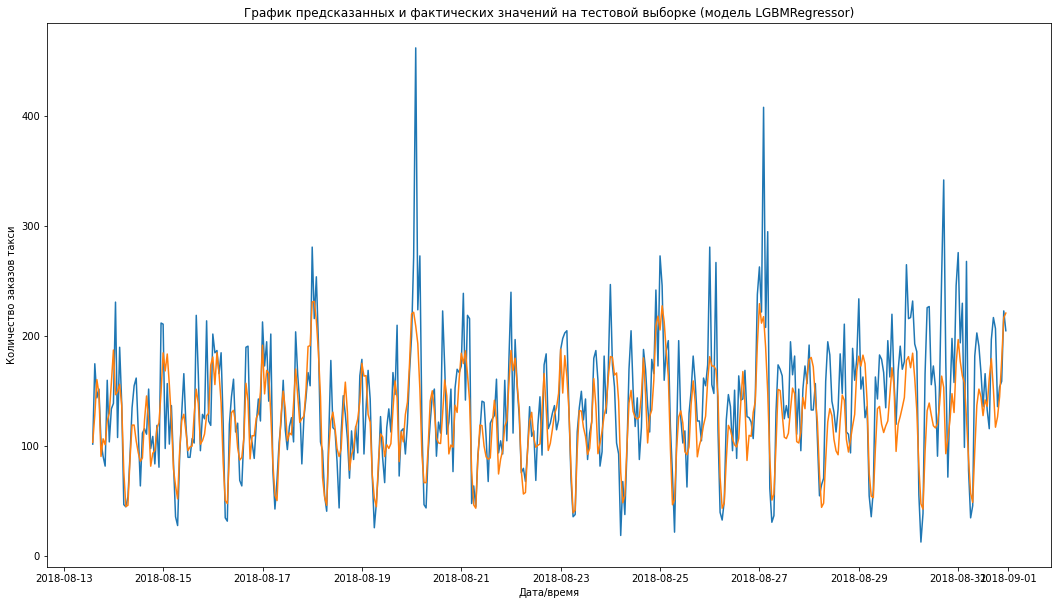

In [30]:
# построим график предсказания и фактических значений для тестовой выборки
plt.figure(figsize=(18, 10))
plt.plot(df_test.index, df_test['num_orders'].values)
plt.plot(df_test.index, gbm_pred_test)
plt.title('График предсказанных и фактических значений на тестовой выборке (модель LGBMRegressor)')
plt.ylabel('Количество заказов такси')
plt.xlabel('Дата/время')
plt.show();

Предсказания модели **LGBMRegressor**, по сравнению с **базовой моделью Prophet**, намного ближе к фактическим значениям. Как видно из графика выше, большая часть ошибок связанна с выбросами в данных (пиковые значения), а так же с переходящим процессом в интервале дат `2018-08-28` - `2018-08-31`. Возможно конец августа является самым востребованным (конец отпусков, предстоящее начало учебного года).

## Общий вывод:

В ходе работы было выполнено:
1. загружены данные, проведена начальная предобработка (данные проверены на пропуски, аномальные значения, монотонность, данные ресемплированы с интервалом в один час с суммированием количества заказов);
2. проведен анализ целевого признака (количество заказов такси), получена и проанализирована информация о тренде, сезонности и остатков;
3. обучена базовая модель с использованием библиотеки **Prophet**;
4. создан **собственный класс `'DataPreprocess'` для этапа Pipeline**, в котором из данных извлекаются календарные признаки, признаки на основе смещения и оконного подсчета среднего, а так же трёх доролнительных признака (`'trend'`, `'daily'`, `'weekly'`) из обученной модели **Prophet**;
5. данные предварительно разбиты на обучающую и тестовую выборки;
6. с подбором гиперпараметров и **кросс-валидации на 3-х фолдах** с помощью **GridSearchCV** обучены 3 модели: **'LGBMRegressor', 'XGBRegressor', 'CatBoostRegressor'**;
7. выбрана лучшая модель по результатам **метрики RMSE**;
8. лучшая модель оценена на тестовой (отложенной) выборке;
9. сделан вывод и даны рекомендации для возможного улучшения работы.

В ходе анализа было выявлено:
- **среднее значение заказов** в течение 10 минут составляет **14 заказов**;
- распределение значений целевого признака `'num_orders'`(*количество заказов*) **соответствует Пуассоновскому распределению**;
- отмечен **восходящий тренд среднего количества заказов такси с апреля по конец августа 2018 года** (временной ряд **не стационарен**). Так же в августе отмечается **4 аномально высоких значений количества заказов**;
- присутствует сезонность в дне недели. Например в каждый 6-ой день месяца количество заказов значительно больше, чем в предыдущий 5-ый день;
- так же присутствует сезонность во времени суток. Ближе к 6 утра количество заказов минимально, пик наблюдается во второй половине дня и ночью;
- в остатках наблюдаются отмеченные ранее пики в агусте месяце.

Лучшей моделью по метрике RMSE на кросс-валидации признана модель **LGBMRegressor** (**RMSE на CV - 25.568**, **RMSE на тестовой выборке - 39.767**). Качество модели на тестовой выборке подходит под условия Заказчика (**RMSE не более 48**).

Предсказания модели **LGBMRegressor**, по сравнению с базовой моделью **Prophet**, намного ближе к фактическим значениям. Большая часть ошибок связанна **с выбросами** в данных (пиковые значения), а так же **с переходящим процессом** в интервале дат `2018-08-28` - `2018-08-31`. Возможно конец августа является самым востребованным (конец отпусков, предстоящее начало учебного года).

## Рекомендации:

1. **Собрать данные за последние 3 года** или более для отслеживания годовой сезонности. Такие данные могут позволить улучшить качество модели.
2. Определить **причину выбросов (пиков) в августе**. Если такие пики действительно являются фактом и их сложно предсказывать, возможно рассмотреть более робастную метрику (например **mean_absolute_error**).
3. Предложить рассмотреть разработку модель с использованием **преобразования Фурье**.